In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import os
import random

import helper_functions as helper

In [2]:
with open('data_path.txt', 'r') as f:
    data_path = os.path.join(f.readline(), 'steering')

file_path = os.path.join(data_path, 'MarkkulaEtAl_BiolCyb2018_DataWithIntermittentInterpretation.mat')
data = helper.loadmat(file_path)

sightpoint_filepath = os.path.join(data_path, 'PreCalculatedSightPointSignalData.mat')
sightpoint_data = helper.loadmat(sightpoint_filepath)['SSightPointPreCalc']

lk_data = data['STasks'][0]
lk_sightpoint_data = sightpoint_data.STasks[0]
lk_subjects = np.arange(1, 16)

# cd_data = data['STasks'][1]
# cd_sightpoint_data = sightpoint_data.STasks[1]
# cd_subjects = np.arange(1, 9)

# Prepare passive phase data

In [3]:
(5 != 2)

True

In [4]:
def get_p(sightpoint_recording, p_weights):
    near_sightpoint = (sightpoint_recording.SSightPointPreviewTimes[0].SPathVariants.SSightPointSignals)
    nsp_angle = near_sightpoint.VSightPointAngle
    nsp_rate = near_sightpoint.VSightPointRate

    far_sightpoint = (sightpoint_recording.SSightPointPreviewTimes[1].SPathVariants.SSightPointSignals)
    fsp_angle = far_sightpoint.VSightPointAngle
    fsp_rate = far_sightpoint.VSightPointRate
    
    p = p_weights['k_nI']*nsp_angle + p_weights['k_nP']*nsp_rate + p_weights['k_f']*fsp_rate
    
    return p

def get_passive_phase_data(data, sightpoint_data, p_weights, delay):
    passive_phases = []
    for i, driver in enumerate(data.SDrivers):
        for j, recording in enumerate(driver.SRecordings):
            # VSWRate from the original data is a bit oversmoothed, which might lead to underestimation of 
            # inter-adjustment intervals, so we try an alternative numerical differentiation algo here
            v = helper.differentiate(recording.SSignals.VTimeStamp, recording.SSignals.VSWAngle)
            
            starting_points, action_points = helper.extract_passive_phases(v)
            
            if (len(starting_points) != len(action_points)):
                raise AssertionError('Mismatch in the number of starting/action points')
            elif len(starting_points)>0:
                # we're looking at passive phases, so sensorimotor delays supposedly affect action points
                # but not starting points of passive phases. The reason is that corrective adjustments are open-loop,
                # so their final part doesn't depend on the system state. However, the end of a passive phase
                # (action point) is driven by the system state, supposedly delayed          
                # in the lane-keeping task sampling frequency was 60Hz (time step 16.7ms)
                delay_n = int(round(delay/16.7))

                delayed_ap = np.array(action_points) - delay_n
                delayed_ap[delayed_ap<=0] = 0

                t_sp = recording.SSignals.VTimeStamp[starting_points]
                t_ap = recording.SSignals.VTimeStamp[delayed_ap]

                p = get_p(sightpoint_data.SDrivers[i].SRecordings[j], p_weights)

                df = pd.DataFrame({'subject': i+1,
                                   'recording': j+1,
                                   'passive_phase_number': np.arange(1, len(starting_points)+1),
                                   'idx_sp': starting_points,
                                   'idx_ap': action_points,
                                   't_sp': t_sp, 
                                   't_ap': t_ap,
                                   'p_sp': abs(p[starting_points]),
                                   'p_ap': abs(p[delayed_ap])})

                passive_phases.append(df)
    
    passive_phases = pd.concat(passive_phases).set_index(['subject', 'recording'], drop=False)
    
    # there are problematic passive phases consisting of just one data point, we discard them
    # with the sampling rate of 60Hz those are apparently false alarms
    passive_phases = passive_phases[passive_phases.idx_ap - passive_phases.idx_sp>1]
    
    passive_phases['delta_t'] = passive_phases.t_ap - passive_phases.t_sp
    
    # we discard outliers with extreme delta_t (>4s without steering adjustments, just about 40 of them in total)
    passive_phases = passive_phases[(passive_phases.delta_t>0) & (passive_phases.delta_t<4)]
    passive_phases['log_delta_t'] = np.log(passive_phases.delta_t)   
    passive_phases['log_p_sp'] = np.log(passive_phases.p_sp)
    passive_phases['p_sp_decile'] = pd.qcut(passive_phases['p_sp'], 10, labels=np.arange(1,11))
    return passive_phases

def save_passive_phases_to_csv(data, sightpoint_data, task, p_weights, delay):
    passive_phases = get_passive_phase_data(data, sightpoint_data, p_weights, delay)
    passive_phases.to_csv(os.path.join(data_path, 'passive_phases_%s.csv' % (task)), index=False)

In [5]:
p_weights = {'k_nI': 0.02, 'k_nP': 0.2, 'k_f': 1.6}
delay = 0 #ms

save_passive_phases_to_csv(lk_data, lk_sightpoint_data, 'lk', p_weights, delay)
# save_passive_phases_to_csv(cd_data, cd_sightpoint_data, 'cd', p_weights)

# Check passive phase data

In [6]:
passive_phases_lk = pd.read_csv(os.path.join(data_path, 'passive_phases_lk.csv'), index_col=None)
passive_phases_lk = passive_phases_lk.set_index(['subject', 'recording', 'passive_phase_number'], drop=False)
# passive_phases_cd = pd.read_csv(os.path.join(data_path, 'passive_phases_cd.csv'), index_col=None)

# there is an outlier in the circular driving task, better exclude it
# print(passive_phases_cd[passive_phases_cd.p_sp>2])
# passive_phases_cd = passive_phases_cd[passive_phases_cd.p_sp<2]

In [7]:
len(passive_phases_lk)

1892

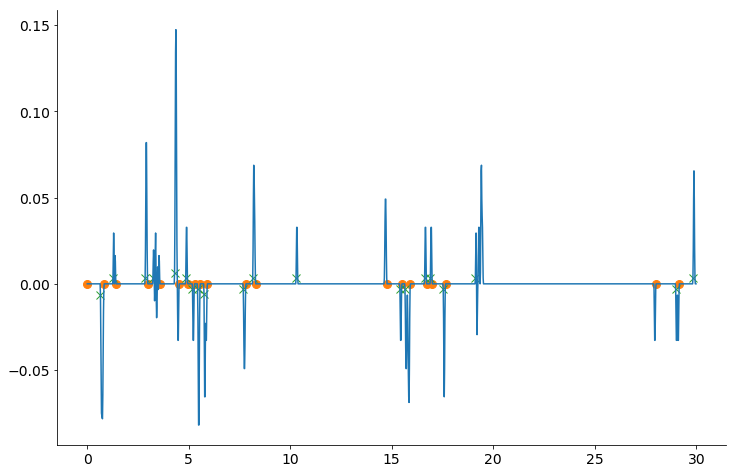

In [8]:
def plot_example_sw_rate(drivers, passive_phases, subject=1, recording=1):
    data = drivers.SDrivers[subject-1].SRecordings[recording-1]
    t = data.SSignals.VTimeStamp
    x = data.SSignals.VSWAngle
    v = helper.differentiate(t, x)

    ap_idx = passive_phases[(passive_phases.subject==subject) & (passive_phases.recording==recording)].idx_ap.values
    sp_idx = passive_phases[(passive_phases.subject==subject) & (passive_phases.recording==recording)].idx_sp.values

    fig, ax = plt.subplots(figsize=(12,8))    
    ax.plot(t[sp_idx], v[sp_idx], ls='', marker='o', ms=8, color='C1')
    ax.plot(t[ap_idx], v[ap_idx], ls='', marker='x', ms=8, color='C2')
    ax.plot(t, v)
#     ax.set_xlim([0,5])
    
plot_example_sw_rate(lk_data, passive_phases_lk, subject=1, recording=2)
# plot_example_sw_rate(cd_data, passive_phases_cd, subject=1, recording=2)

# Exploring $\Delta_t$ distributions

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


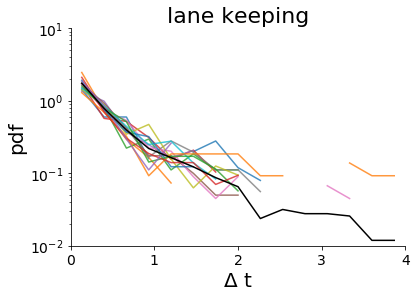

In [9]:
def plot_delta_t_hist(data, task, xlim):
    ax = helper.plot_pdf(data=data, var='delta_t', bins=np.linspace(0, xlim[1], 16))
#     ax = helper.plot_pdf(data=data, var='delta_t', bins=25)
    ax.set_xlabel('$\Delta$ t')
#     ax.set_ylabel('pdf')
    ax.set_xlim(xlim)
    ax.set_ylim((0.01, 10))
    ax.set_title(task)
    
    return ax
    
ax = plot_delta_t_hist(passive_phases_lk, 'lane keeping', (0., 4))
plt.savefig('figures/delta_t_pdf_lk.png')

# ax = plot_delta_t_hist(passive_phases_cd, 'circular driving', (0., 2))
# plt.savefig('figures/delta_t_pdf_cd.png')

# $p_{AP}$ distributions

(0.1, 500)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


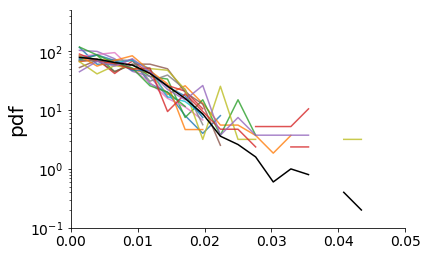

In [10]:
ax = helper.plot_pdf(data=passive_phases_lk, var='p_ap', bins=np.linspace(0, 0.05, 20))
ax.set_xlim((0.0, 0.05))
ax.set_ylim((0.1, 500))

# ax = helper.plot_pdf(data=passive_phases_cd, var='p_ap', bins=np.linspace(0, 0.3, 20))
# ax.set_xlim((0.0, 0.3))
# ax.set_ylim((0.05, 50))

# $p_{SP}$ distributions

(0.1, 500)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


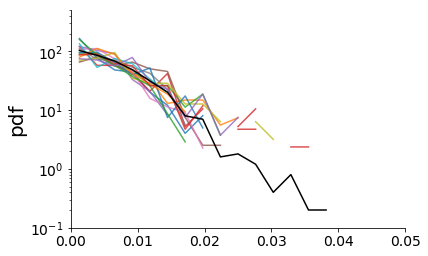

In [11]:
ax = helper.plot_pdf(data=passive_phases_lk, var='p_sp', bins=np.linspace(0, 0.05, 20))
ax.set_xlim((0.0, 0.05))
ax.set_ylim((0.1, 500))

# ax = helper.plot_pdf(data=passive_phases_cd, var='p_sp', bins=np.linspace(0, 0.3, 20))
# ax.set_xlim((0.0, 0.3))
# ax.set_ylim((0.05, 50))

# Joint $p_{SP}$ vs $\Delta_t$ distributions

Assuming $p_{SP}$ is driving the decision to start steering, how does the adjustment initiation time change with $p_{SP}$?

In the lane keeping task, $\Delta_t$ generally decreases with $p_{SP}$

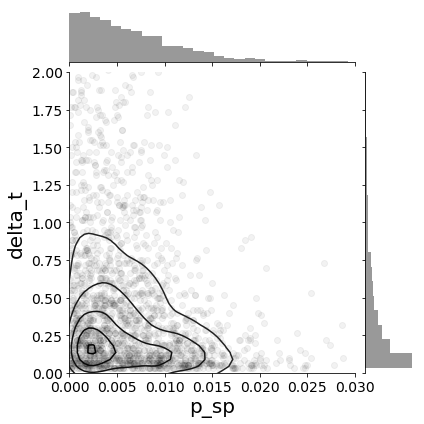

In [12]:
(sns.jointplot(x=passive_phases_lk.p_sp, y=passive_phases_lk.delta_t, alpha=0.05, xlim=(0, 0.03), ylim=(0, 2), color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

To make this clearer, we'll plot average $\Delta_t$ for every decile of $p_{SP}$.

In the lane keeping task, $\Delta_t$ decreases from about 700-800ms for the least pressing situations to about 200ms for situations where the $p_{SP}$ is very large already in the beginning of a passive phase.

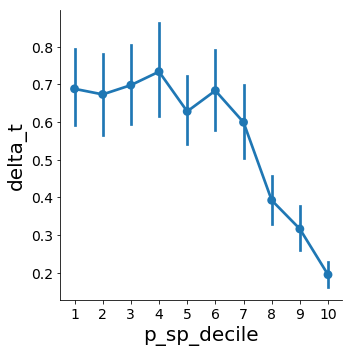

In [13]:
sns.catplot(data=passive_phases_lk, x='p_sp_decile', y='delta_t', kind='point')

# Try looking at log-scaled $\Delta_t$ and $p_{SP}$?

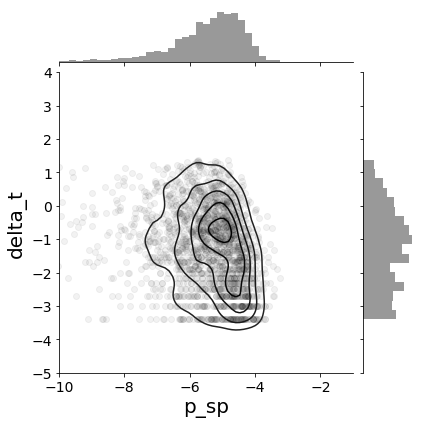

In [14]:
(sns.jointplot(x=np.log(passive_phases_lk[passive_phases_lk.p_sp>0].p_sp), 
               y=np.log(passive_phases_lk[passive_phases_lk.p_sp>0].delta_t), 
               xlim=(-10, -1), ylim=(-5, 4),
               alpha=0.05, color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

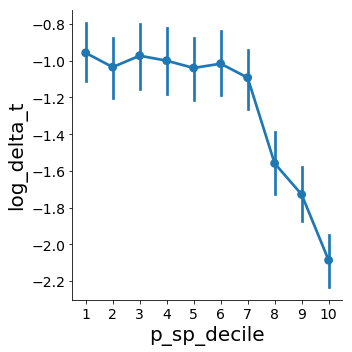

In [15]:
sns.catplot(data=passive_phases_lk, x='p_sp_decile', y='log_delta_t', kind='point')
# sns.factorplot(data=passive_phases_cd, x='p_sp_decile', y='log_delta_t', kind='point')

# Dynamics of $p$ in the passive phase 

In [16]:
def get_p_dynamics(passive_phase, sightpoint_data):
    p_weights = {'k_nI': 0.02, 'k_nP': 0.2, 'k_f': 1.6}
    subject, recording = passive_phase.name[0]-1, passive_phase.name[1]-1
    p = get_p(sightpoint_data.SDrivers[subject].SRecordings[recording], p_weights=p_weights)
    
    return pd.Series(p[int(passive_phase.idx_sp):int(passive_phase.idx_ap+1)])
    
p_dynamics_lk = passive_phases_lk.groupby(['subject', 
                                           'recording', 
                                           'passive_phase_number']).apply(lambda p: 
                                                                          get_p_dynamics(p, lk_sightpoint_data))
p_dynamics_lk.index = p_dynamics_lk.index.droplevel(3)

def get_adjustment_dynamics(passive_phase, driving_data):
    subject, recording = passive_phase.name[0]-1, passive_phase.name[1]-1
    recording_data = driving_data.SDrivers[subject].SRecordings[recording]
    sw_rate = helper.differentiate(recording_data.SSignals.VTimeStamp, recording_data.SSignals.VSWAngle)
    
    return pd.Series(sw_rate[int(passive_phase.idx_sp):int(passive_phase.idx_ap+1)])
    
v_dynamics_lk = passive_phases_lk.groupby(['subject', 'recording', 
                                       'passive_phase_number']).apply(lambda p: 
                                                                      get_adjustment_dynamics(p, lk_data))
v_dynamics_lk.index = v_dynamics_lk.index.droplevel(3)

v_sign = np.sign(v_dynamics_lk.groupby(v_dynamics_lk.index.names).last())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 'subject' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 'recording' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 'passive_phase_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: 'subject' is both an index level and a column label.
Defaulting to column, but this w

In [26]:
def plot_p(p_dynamics, v_sign):
    threshold = 0.002
    if (p_dynamics.iloc[0] - p_dynamics.iloc[-1] < -threshold):
        color='C0'
    elif(p_dynamics.iloc[0] - p_dynamics.iloc[-1] > threshold):
        color='C1'
    else:
        color='grey'
            
    plt.plot(np.linspace(0, len(p_dynamics)/60, len(p_dynamics)), p_dynamics, color=color, alpha=0.6)
    
    marker_color = 'C0' if v_sign.loc[p_dynamics.name] > 0 else 'C1'       
    plt.plot([len(p_dynamics)/60], [p_dynamics[-1]], color=marker_color, marker='o', ms='3', ls='')

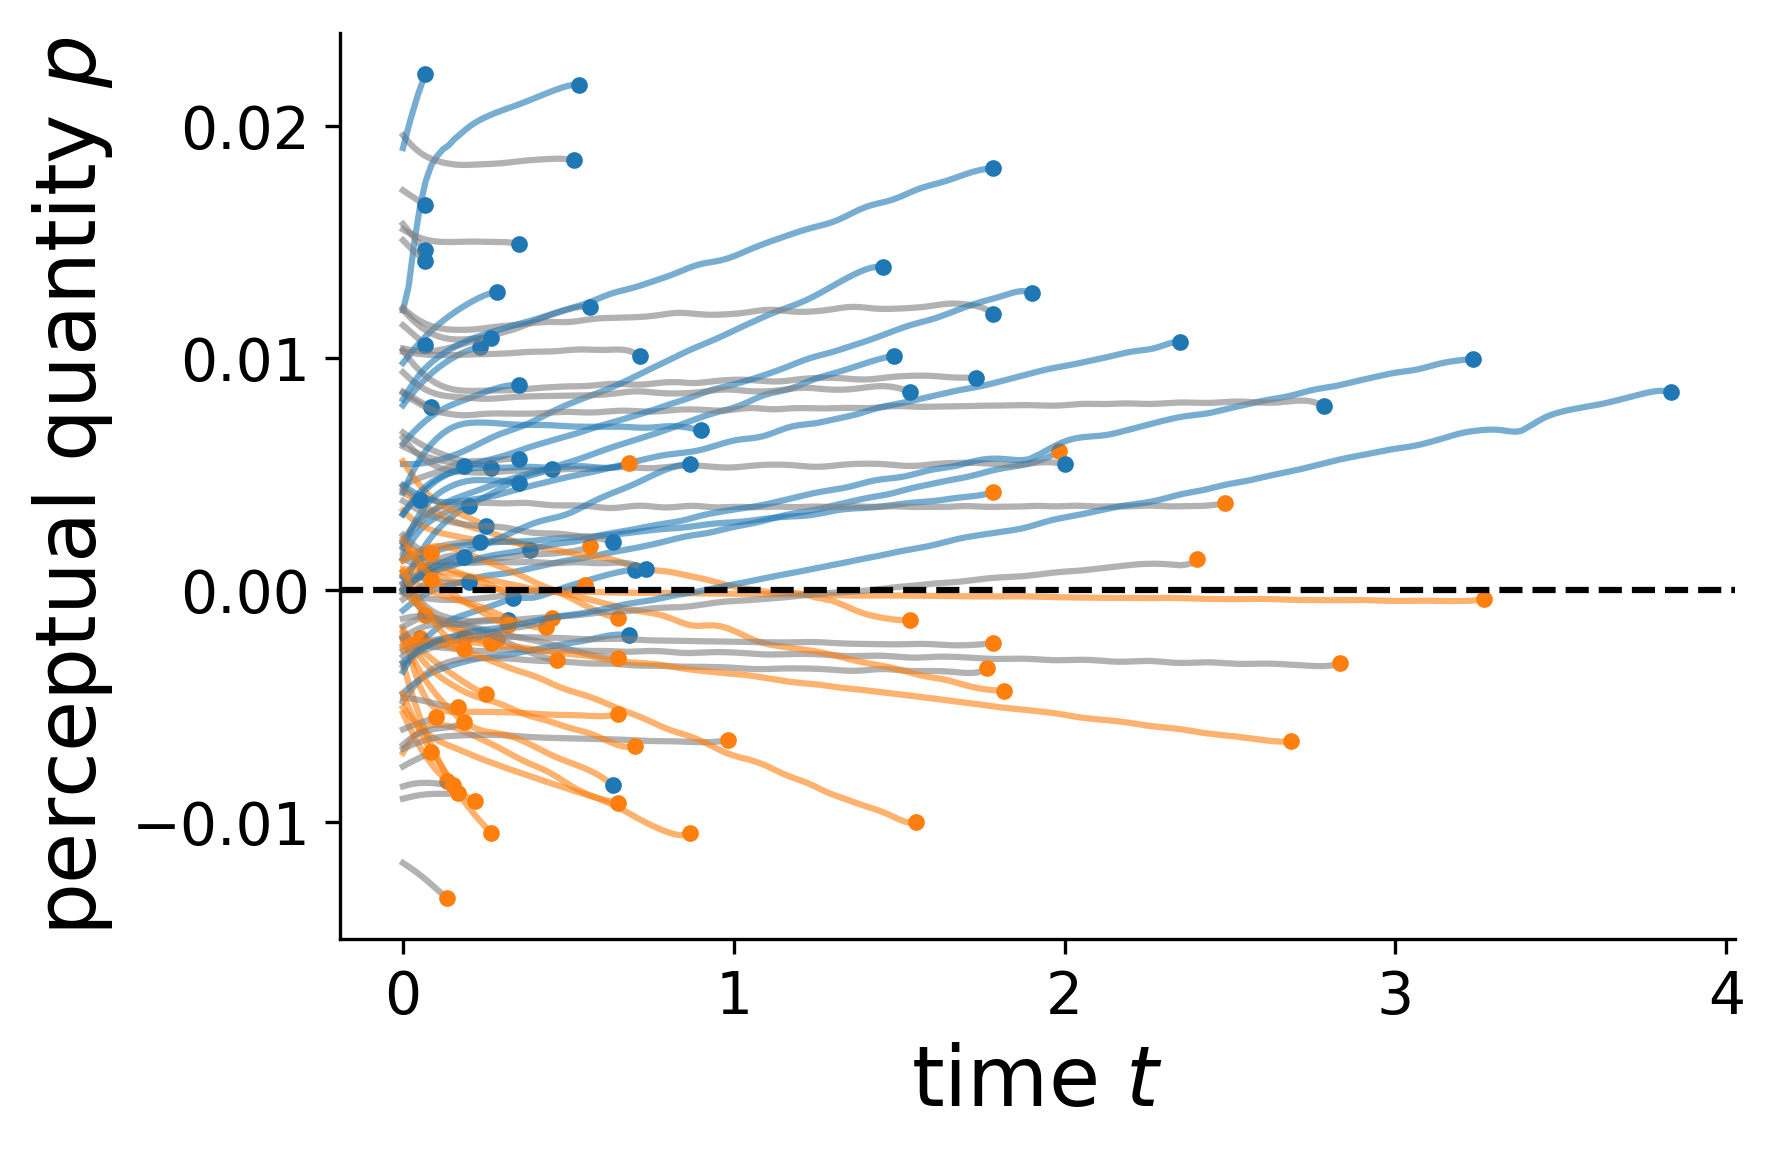

In [27]:
subj = 1

fig, ax = plt.subplots(1, dpi=300)
p_dynamics_lk[subj].groupby(['recording', 'passive_phase_number']).apply(lambda p: plot_p(p, v_sign[subj]));

ax.axhline(0.0, color='k', ls='--')
ax.set_xlabel('time $t$')
ax.set_ylabel('perceptual quantity $p$');

# DDM modeling

First, for a given trajectory of $p$ and a given set of DDM params $A, c$ generate and visualize 100 activations by DDM

In [52]:
p_exp = p_dynamics_lk.loc[1,1,4]
t_exp = np.linspace(0, len(p_exp)/60, len(p_exp))
t_extra = np.linspace(len(p_exp)/60, 2*len(p_exp)/60, len(p_exp))

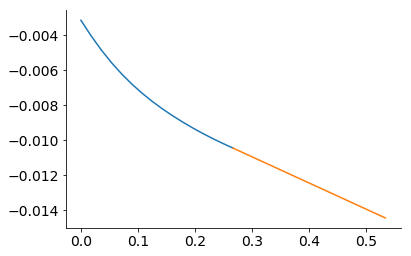

In [53]:
plt.plot(t_exp, p_exp)

plt.plot(t_extra, p_extra(t_extra))


In [41]:
p

subject  recording  passive_phase_number
1        1          4                      -0.003155
                    4                      -0.004044
                    4                      -0.004847
                    4                      -0.005569
                    4                      -0.006215
                    4                      -0.006793
                    4                      -0.007312
                    4                      -0.007780
                    4                      -0.008206
                    4                      -0.008599
                    4                      -0.008964
                    4                      -0.009304
                    4                      -0.009622
                    4                      -0.009920
                    4                      -0.010199
                    4                      -0.010465
dtype: float64

In [56]:
def dx(A, c, dt):
    return A*dt + c*np.random.randn()*np.sqrt(dt)

def run_trial(c, b, p):
    dt = (1/60)/10
    ts = [0]
    ps = [p(0)]
    xs = [0]
    
    while abs(xs[-1]) < b:               
        t = ts[-1] + dt
        
        # stimulus strength $p$ at time t
        ps.append(p(t))
        
        # accumulated evidence $x$ at time t
        xs.append(xs[-1] + dx(p(t), c, dt))
        ts.append(t)
        
    return np.array(ts), np.array(xs), np.array(ps)

def run_sim(c, b, p_exp, n_sim):
    trials = []
    t_exp = np.linspace(0, len(p_exp)/60, len(p_exp))
    p_interp = sp.interpolate.interp1d(x=t_exp, y=p_exp, fill_value='extrapolate')
    for n in range(n_sim):        
        ts, xs, ps = run_trial(c, b, p_interp)
        # if the sign of boundary reached by accumulator is the same as the sign of $p$, we count a trial as correct
        is_correct = (xs[-1]*ps[-1] > 0)
        
        # n : simulation number 
        # t : time
        # x: accumulated evidence at time t
        # p: perceptual quantity at time t
        # is_correct: whether "correct" boundary is hit (-b for p[-1]<0, +b for p[-1]>0)
        trials.append(pd.DataFrame(data={'n': n, 't': ts, 'x': xs, 'p': ps, 'is_correct': is_correct}))
    return pd.concat(trials).set_index(['n'])

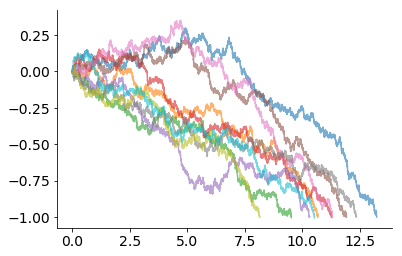

In [59]:
sim_results = run_sim(0.1, 1, p, 10)
for n, sim_result in sim_results.groupby('n'):
    plt.plot(sim_result.t, sim_result.x, alpha=0.6)